Ver 2

In [51]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import re

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import (
    DistilBertTokenizerFast,
    DistilBertConfig,
    DistilBertModel,
    DistilBertPreTrainedModel,
    Trainer,
    TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.preprocessing import MultiLabelBinarizer


import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import torch
from sentence_transformers import SentenceTransformer
device = "cuda" if torch.cuda.is_available() else "cpu"
import sys
print("Python executable:", sys.executable)
print(device)
print("Torch version:", torch.__version__)
print("Torch CUDA version:", torch.version.cuda)
print("Is CUDA available?", torch.cuda.is_available())
model = SentenceTransformer("distilbert-base-nli-mean-tokens", device=device)
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import nltk
from nltk.corpus import stopwords
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler






reviews_df = pd.read_json("../.cache/kagglehub/datasets/rmisra/imdb-spoiler-dataset/versions/1/IMDB_reviews.json", lines=True)
movie_details_df = pd.read_json("../.cache/kagglehub/datasets/rmisra/imdb-spoiler-dataset/versions/1/IMDB_movie_details.json", lines=True)

Python executable: c:\Users\jz\.conda\envs\cs3244_proj\python.exe
cuda
Torch version: 2.6.0+cu118
Torch CUDA version: 11.8
Is CUDA available? True


In [52]:
# Assume reviews_df and movie_details_df have been loaded earlier:
merged_df = pd.merge(reviews_df, movie_details_df, on='movie_id', how='left')
merged_df = merged_df.rename(columns={
    "rating_x": "review_rating",   # from the reviews data
    "rating_y": "movie_rating"     # from the movie details
})

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return " ".join([word for word in text.split() if word not in stop_words])

def parse_duration(duration_str):
    if pd.isna(duration_str): return np.nan
    pattern = re.compile(r"(\d+)h\s*(\d+)min")
    match = pattern.search(duration_str)
    return int(match.group(1)) * 60 + int(match.group(2)) if match else np.nan

def convert_to_minutes(duration_str):
    if pd.isna(duration_str):
        return np.nan
    duration_str = duration_str.strip().lower()
    
    hours_match = re.search(r"(\d+)\s*h", duration_str)
    minutes_match = re.search(r"(\d+)\s*min", duration_str)

    hours = int(hours_match.group(1)) if hours_match else 0
    minutes = int(minutes_match.group(1)) if minutes_match else 0

    if hours == 0 and minutes == 0:
        return np.nan  # no valid time found
    return hours * 60 + minutes

def split_genres(genre_str):
    if isinstance(genre_str, (list, np.ndarray)): return list(genre_str)
    if pd.isna(genre_str): return []
    return genre_str.split('|') if isinstance(genre_str, str) else []

# Clean and feature engineer
merged_df['genre_list'] = merged_df['genre'].apply(split_genres)
merged_df['duration_minutes'] = merged_df['duration'].apply(parse_duration)
mlb = MultiLabelBinarizer()
genre_encoded_df = pd.DataFrame(mlb.fit_transform(merged_df['genre_list']), columns=mlb.classes_)
df_encoded = pd.concat([merged_df, genre_encoded_df], axis=1)

df_encoded['movie_rating'] = pd.to_numeric(df_encoded['movie_rating'], errors='coerce')
df_encoded['review_rating'] = pd.to_numeric(df_encoded['review_rating'], errors='coerce').astype('Int64')
df_encoded['release_date'] = pd.to_datetime(df_encoded['release_date'], errors='coerce')
df_encoded['review_date'] = pd.to_datetime(df_encoded['review_date'], errors='coerce')
df_encoded['is_spoiler'] = df_encoded['is_spoiler'].astype(int)

df_encoded['plot_summary'] = df_encoded['plot_summary'].map(clean_text)
df_encoded['plot_synopsis'] = df_encoded['plot_synopsis'].map(clean_text)
df_encoded['review_text'] = df_encoded['review_text'].map(clean_text)
df_encoded['review_summary'] = df_encoded['review_summary'].map(clean_text)

today = pd.to_datetime(datetime.today().date())
df_encoded['days_since_release'] = (today - df_encoded['release_date']).dt.days
df_encoded['days_since_review'] = (today - df_encoded['review_date']).dt.days
df_encoded['duration_min'] = df_encoded['duration'].apply(convert_to_minutes)

# Add user review statistics
review_counts = df_encoded.groupby('user_id').size().rename('user_review_count')
spoiler_counts = df_encoded[df_encoded['is_spoiler'] == 1].groupby('user_id').size().rename('user_spoiler_count')
df_encoded = df_encoded.merge(review_counts, on='user_id', how='left')
df_encoded = df_encoded.merge(spoiler_counts, on='user_id', how='left')
df_encoded['user_spoiler_count'] = df_encoded['user_spoiler_count'].fillna(0).astype(int)
df_encoded['user_spoiler_ratio'] = df_encoded['user_spoiler_count'] / df_encoded['user_review_count']


numeric_df = df_encoded.select_dtypes(include=[np.number])
print("df_encoded:")
print(df_encoded.head())
corr_matrix = numeric_df.corr()
print("Correlations with is_spoiler:")
print(corr_matrix['is_spoiler'].sort_values(ascending=False))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


df_encoded:
  review_date   movie_id    user_id  is_spoiler  \
0  2006-02-10  tt0111161  ur1898687           1   
1  2000-09-06  tt0111161  ur0842118           1   
2  2001-08-03  tt0111161  ur1285640           1   
3  2002-09-01  tt0111161  ur1003471           1   
4  2004-05-20  tt0111161  ur0226855           1   

                                         review_text  review_rating  \
0  oscar year shawshank redemption written direct...             10   
1  shawshank redemption without doubt one brillia...             10   
2  believe film best story ever told film im tell...              8   
3  yes spoilers herethis film emotional impact fi...             10   
4  heart extraordinary movie brilliant indelible ...              8   

                           review_summary  \
0  classic piece unforgettable filmmaking   
1            simply amazing best film 90s   
2               best story ever told film   
3                  busy dying busy living   
4       great story wondrousl

In [53]:
extra_base_features = [
    "review_rating",      # numeric (integer)
    "movie_rating",       # numeric (float)
    "duration_minutes",   # numeric (int/float)
    "days_since_release", # numeric (int)
    "days_since_review",  # numeric (int)
    "user_review_count",  # numeric (int)
    "user_spoiler_count", # numeric (int)
    "user_spoiler_ratio"  # numeric (float)
]

# Include all one-hot encoded genre columns (as in your df_encoded)
genre_cols = [
    "Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Drama", 
    "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Musical", 
    "Mystery", "Romance", "Sci-Fi", "Sport", "Thriller", "War", "Western"
]

# Concatenate into a single list – our additional features dimension
additional_feature_cols = extra_base_features + genre_cols

print("Additional feature columns to use (total {}):".format(len(additional_feature_cols)), additional_feature_cols)


Additional feature columns to use (total 29): ['review_rating', 'movie_rating', 'duration_minutes', 'days_since_release', 'days_since_review', 'user_review_count', 'user_spoiler_count', 'user_spoiler_ratio', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [54]:
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42, stratify=df_encoded['is_spoiler'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['is_spoiler'])

ros = RandomOverSampler(random_state=42)
X = train_df.drop(columns=['is_spoiler'])
y = train_df['is_spoiler']
X_resampled, y_resampled = ros.fit_resample(X, y)
balanced_train_df = X_resampled.copy()
balanced_train_df['is_spoiler'] = y_resampled

# Scale all sets consistently
scaler = StandardScaler()
balanced_train_df[extra_base_features] = scaler.fit_transform(balanced_train_df[extra_base_features])
val_df[extra_base_features] = scaler.transform(val_df[extra_base_features])
test_df[extra_base_features] = scaler.transform(test_df[extra_base_features])
balanced_train_df[extra_base_features] = balanced_train_df[extra_base_features].fillna(0)
val_df[extra_base_features] = val_df[extra_base_features].fillna(0)
test_df[extra_base_features] = test_df[extra_base_features].fillna(0)


In [55]:
class SpoilerDataset(Dataset):
    def __init__(self, df, tokenizer, additional_feature_cols, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.additional_feature_cols = additional_feature_cols
        self.max_length = max_length

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        encoded = self.tokenizer(row['review_text'], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        features = torch.tensor([row[col] for col in self.additional_feature_cols], dtype=torch.float32)
        label = torch.tensor(row['is_spoiler'], dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'additional_features': features,
            'labels': label
        }


In [56]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

# Create dataset objects for train, validation, and test
val_dataset   = SpoilerDataset(val_df, tokenizer, additional_feature_cols, max_length=128)
test_dataset  = SpoilerDataset(test_df, tokenizer, additional_feature_cols, max_length=128)

balanced_train_dataset = SpoilerDataset(
    balanced_train_df,  # This is the DataFrame you oversampled
    tokenizer,
    additional_feature_cols,
    max_length=128
)


In [57]:
class DistilBertMultiInputForClassification(DistilBertPreTrainedModel):
    def __init__(self, config, num_additional_features, num_labels=2, class_weights=None):
        super().__init__(config)
        self.num_labels = num_labels
        self.distilbert = DistilBertModel(config)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size + num_additional_features, 128),
            nn.ReLU(),
            nn.Dropout(config.seq_classif_dropout),
            nn.Linear(128, num_labels)
        )
        self.class_weights = class_weights
        self.post_init()

    def forward(self, input_ids=None, attention_mask=None, additional_features=None, labels=None, **kwargs):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0]
        combined = torch.cat((cls_embedding, additional_features), dim=1)
        logits = self.classifier(combined)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()  # No class weights for now
            loss = loss_fct(logits, labels)
        return SequenceClassifierOutput(loss=loss, logits=logits)

# Tokenizer and datasets
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_dataset = SpoilerDataset(balanced_train_df, tokenizer, additional_feature_cols)
val_dataset = SpoilerDataset(val_df, tokenizer, additional_feature_cols)
test_dataset = SpoilerDataset(test_df, tokenizer, additional_feature_cols)
print(train_dataset[0]['labels']) 

tensor(0)


In [58]:
# Assume reviews_df and movie_details_df have been loaded earlier:
merged_df = pd.merge(reviews_df, movie_details_df, on='movie_id', how='left')
merged_df = merged_df.rename(columns={
    "rating_x": "review_rating",   # from the reviews data
    "rating_y": "movie_rating"     # from the movie details
})

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return " ".join([word for word in text.split() if word not in stop_words])

def parse_duration(duration_str):
    if pd.isna(duration_str): return np.nan
    pattern = re.compile(r"(\d+)h\s*(\d+)min")
    match = pattern.search(duration_str)
    return int(match.group(1)) * 60 + int(match.group(2)) if match else np.nan

def convert_to_minutes(duration_str):
    if pd.isna(duration_str):
        return np.nan
    duration_str = duration_str.strip().lower()
    
    hours_match = re.search(r"(\d+)\s*h", duration_str)
    minutes_match = re.search(r"(\d+)\s*min", duration_str)

    hours = int(hours_match.group(1)) if hours_match else 0
    minutes = int(minutes_match.group(1)) if minutes_match else 0

    if hours == 0 and minutes == 0:
        return np.nan  # no valid time found
    return hours * 60 + minutes

def split_genres(genre_str):
    if isinstance(genre_str, (list, np.ndarray)): return list(genre_str)
    if pd.isna(genre_str): return []
    return genre_str.split('|') if isinstance(genre_str, str) else []

# Clean and feature engineer
merged_df['genre_list'] = merged_df['genre'].apply(split_genres)
merged_df['duration_minutes'] = merged_df['duration'].apply(parse_duration)
mlb = MultiLabelBinarizer()
genre_encoded_df = pd.DataFrame(mlb.fit_transform(merged_df['genre_list']), columns=mlb.classes_)
df_encoded = pd.concat([merged_df, genre_encoded_df], axis=1)

df_encoded['movie_rating'] = pd.to_numeric(df_encoded['movie_rating'], errors='coerce')
df_encoded['review_rating'] = pd.to_numeric(df_encoded['review_rating'], errors='coerce').astype('Int64')
df_encoded['release_date'] = pd.to_datetime(df_encoded['release_date'], errors='coerce')
df_encoded['review_date'] = pd.to_datetime(df_encoded['review_date'], errors='coerce')
df_encoded['is_spoiler'] = df_encoded['is_spoiler'].astype(int)

df_encoded['plot_summary'] = df_encoded['plot_summary'].map(clean_text)
df_encoded['plot_synopsis'] = df_encoded['plot_synopsis'].map(clean_text)
df_encoded['review_text'] = df_encoded['review_text'].map(clean_text)
df_encoded['review_summary'] = df_encoded['review_summary'].map(clean_text)

today = pd.to_datetime(datetime.today().date())
df_encoded['days_since_release'] = (today - df_encoded['release_date']).dt.days
df_encoded['days_since_review'] = (today - df_encoded['review_date']).dt.days
df_encoded['duration_min'] = df_encoded['duration'].apply(convert_to_minutes)

# Add user review statistics
review_counts = df_encoded.groupby('user_id').size().rename('user_review_count')
spoiler_counts = df_encoded[df_encoded['is_spoiler'] == 1].groupby('user_id').size().rename('user_spoiler_count')
df_encoded = df_encoded.merge(review_counts, on='user_id', how='left')
df_encoded = df_encoded.merge(spoiler_counts, on='user_id', how='left')
df_encoded['user_spoiler_count'] = df_encoded['user_spoiler_count'].fillna(0).astype(int)
df_encoded['user_spoiler_ratio'] = df_encoded['user_spoiler_count'] / df_encoded['user_review_count']


numeric_df = df_encoded.select_dtypes(include=[np.number])
print("df_encoded:")
print(df_encoded.head())
corr_matrix = numeric_df.corr()
print("Correlations with is_spoiler:")
print(corr_matrix['is_spoiler'].sort_values(ascending=False))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


df_encoded:
  review_date   movie_id    user_id  is_spoiler  \
0  2006-02-10  tt0111161  ur1898687           1   
1  2000-09-06  tt0111161  ur0842118           1   
2  2001-08-03  tt0111161  ur1285640           1   
3  2002-09-01  tt0111161  ur1003471           1   
4  2004-05-20  tt0111161  ur0226855           1   

                                         review_text  review_rating  \
0  oscar year shawshank redemption written direct...             10   
1  shawshank redemption without doubt one brillia...             10   
2  believe film best story ever told film im tell...              8   
3  yes spoilers herethis film emotional impact fi...             10   
4  heart extraordinary movie brilliant indelible ...              8   

                           review_summary  \
0  classic piece unforgettable filmmaking   
1            simply amazing best film 90s   
2               best story ever told film   
3                  busy dying busy living   
4       great story wondrousl

In [59]:
def custom_collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'additional_features': torch.stack([item['additional_features'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch])
    }

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

# Model, Config, Training
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
model = DistilBertMultiInputForClassification(config, num_additional_features=len(additional_feature_cols))

training_args = TrainingArguments(
    output_dir="./spoiler_model_checkpoint_v2",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    optim="adamw_torch",
    fp16=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_collate_fn,
    compute_metrics=compute_metrics
)


In [60]:
# In[11]: Train the model
trainer.train()

# Evaluate on the validation set
val_results = trainer.evaluate()
print("Validation Results:", val_results)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.181100,0.235780,0.921661,0.902482
2,0.162100,0.258776,0.921156,0.901607
3,0.163400,0.319786,0.919239,0.897227


Validation Results: {'eval_loss': 0.23577961325645447, 'eval_accuracy': 0.9216608731258114, 'eval_f1': 0.9024823675531246, 'eval_runtime': 294.9953, 'eval_samples_per_second': 389.101, 'eval_steps_per_second': 48.638, 'epoch': 3.0}


In [61]:
# In[13]: Save the model and tokenizer
trainer.save_model("./my_spoiler_model_v2")
tokenizer.save_pretrained("./my_spoiler_model_v2")

('./my_spoiler_model_v2\\tokenizer_config.json',
 './my_spoiler_model_v2\\special_tokens_map.json',
 './my_spoiler_model_v2\\vocab.txt',
 './my_spoiler_model_v2\\added_tokens.json',
 './my_spoiler_model_v2\\tokenizer.json')

In [62]:
# In[12]: Predict on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_df['is_spoiler'].values

print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     84598
           1       0.81      0.91      0.86     30185

    accuracy                           0.92    114783
   macro avg       0.89      0.92      0.90    114783
weighted avg       0.93      0.92      0.92    114783



Visualisation of findings.

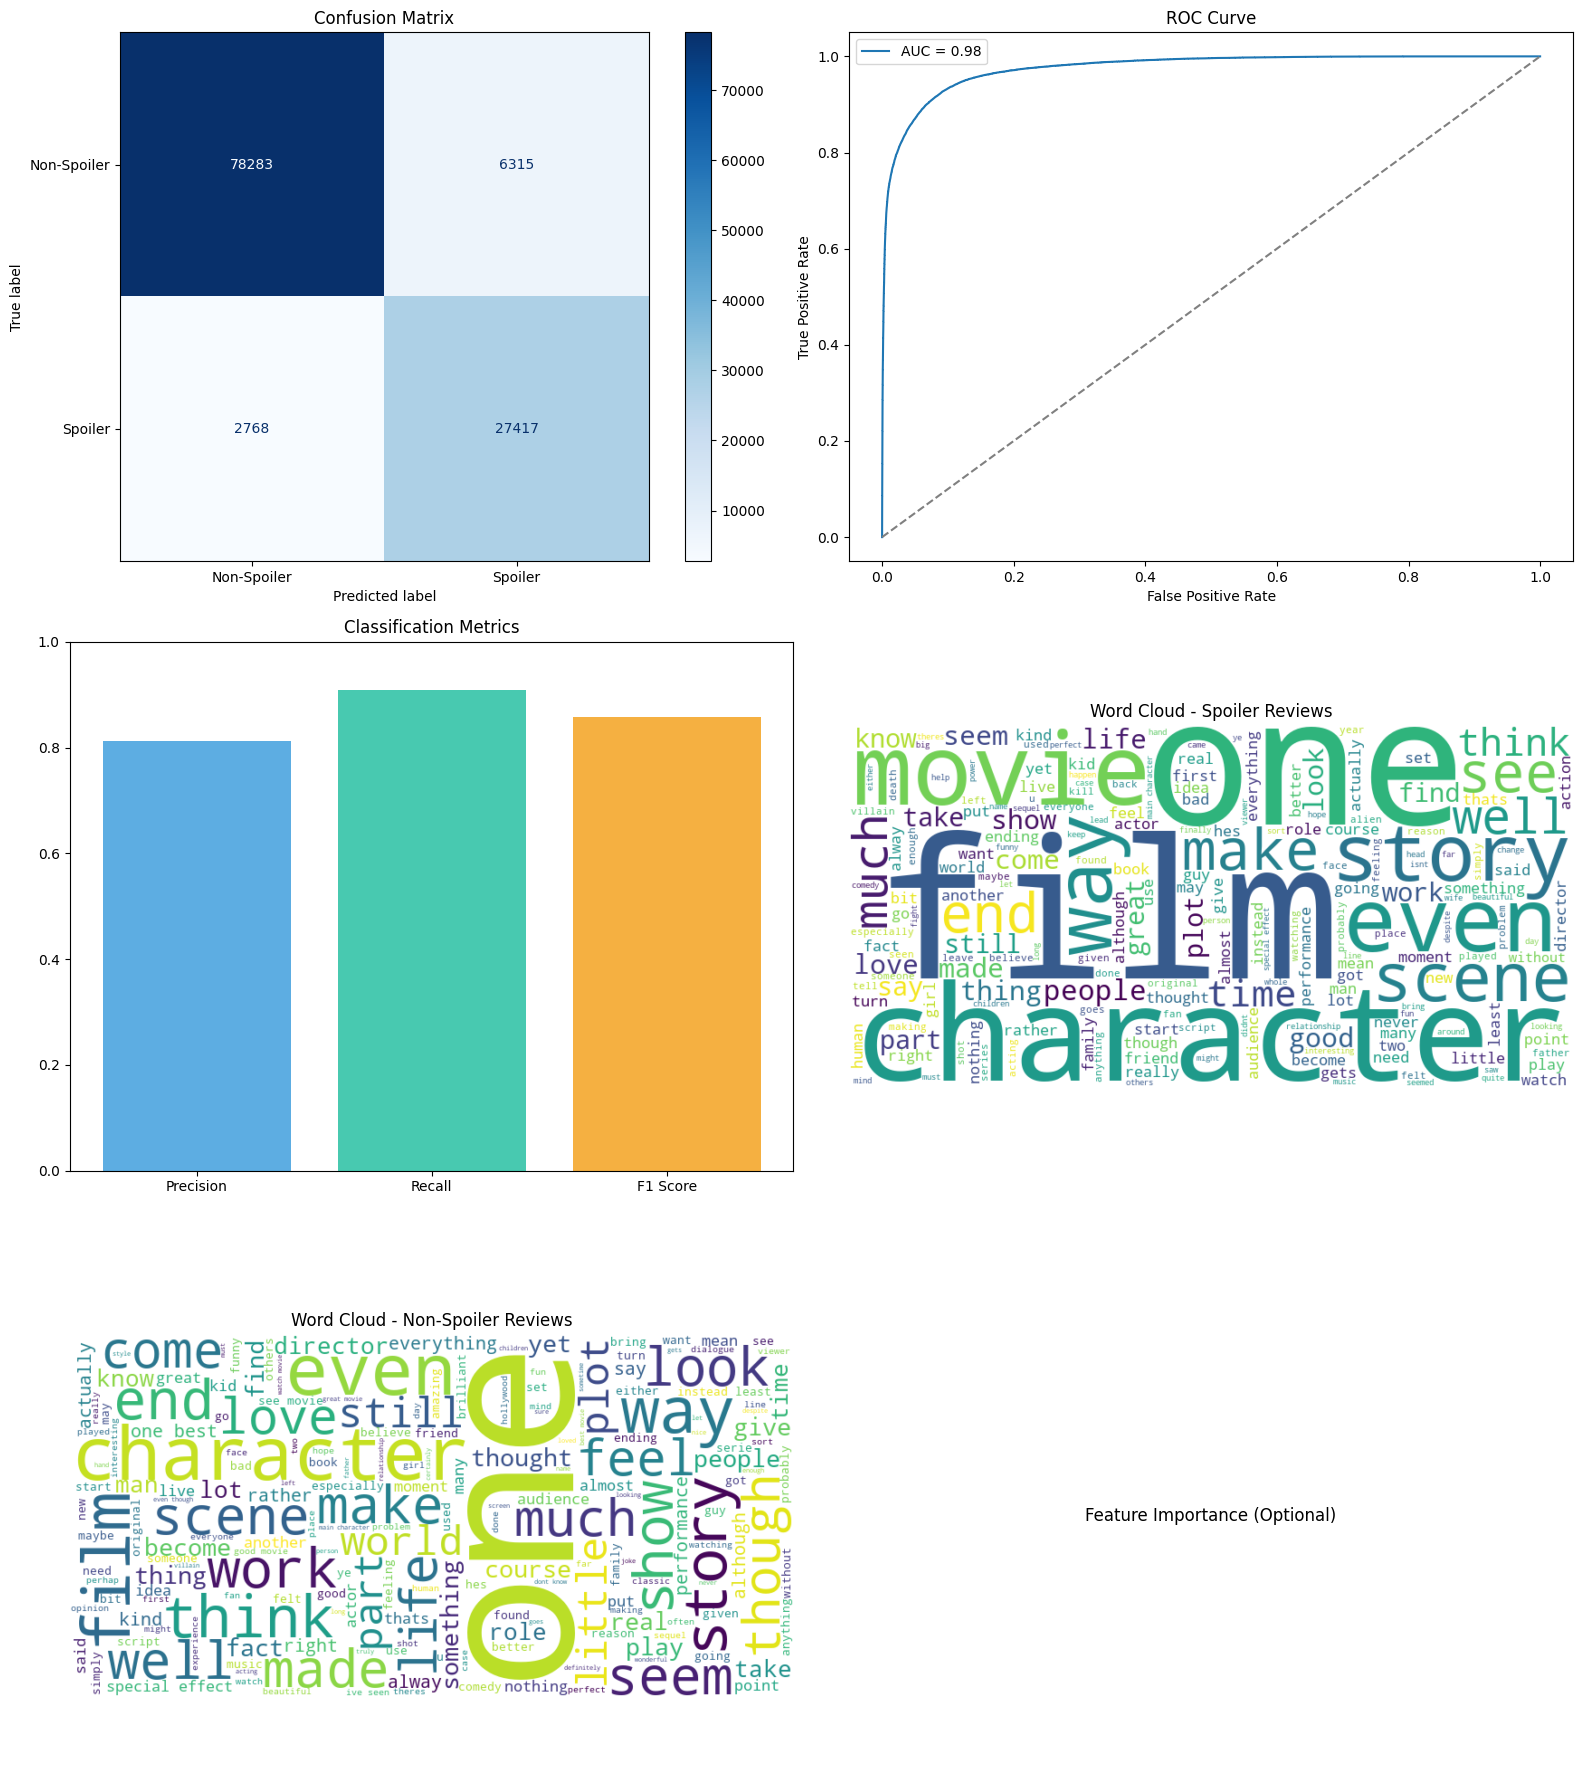

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score
)
from wordcloud import WordCloud

# ---- 1. Get predictions from the trained model ----
raw_preds = trainer.predict(test_dataset)
logits = raw_preds.predictions
y_pred = np.argmax(logits, axis=1)
y_true = raw_preds.label_ids
probs = logits[:, 1]  # probability for class 1 (spoiler)

# ---- 2. Plot all visualizations together ----
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Spoiler", "Spoiler"])
disp.plot(ax=axes[0], cmap="Blues", values_format='d')
axes[0].set_title("Confusion Matrix")

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", color='grey')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend()

# 3. Precision, Recall, F1 Score Bar Chart
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
metrics = [precision, recall, f1]
axes[2].bar(["Precision", "Recall", "F1 Score"], metrics, color=["#5DADE2", "#48C9B0", "#F5B041"])
axes[2].set_ylim(0, 1)
axes[2].set_title("Classification Metrics")

# 4. Word Cloud - Spoiler Reviews
spoiler_text = " ".join(test_df[test_df['is_spoiler'] == 1]['review_text'])
wc_spoiler = WordCloud(width=800, height=400, background_color="white").generate(spoiler_text)
axes[3].imshow(wc_spoiler, interpolation='bilinear')
axes[3].axis("off")
axes[3].set_title("Word Cloud - Spoiler Reviews")

# 5. Word Cloud - Non-Spoiler Reviews
nons_text = " ".join(test_df[test_df['is_spoiler'] == 0]['review_text'])
wc_nons = WordCloud(width=800, height=400, background_color="white").generate(nons_text)
axes[4].imshow(wc_nons, interpolation='bilinear')
axes[4].axis("off")
axes[4].set_title("Word Cloud - Non-Spoiler Reviews")

plt.tight_layout()
plt.show()

PermutationExplainer explainer: 6it [01:45, 21.00s/it]                       


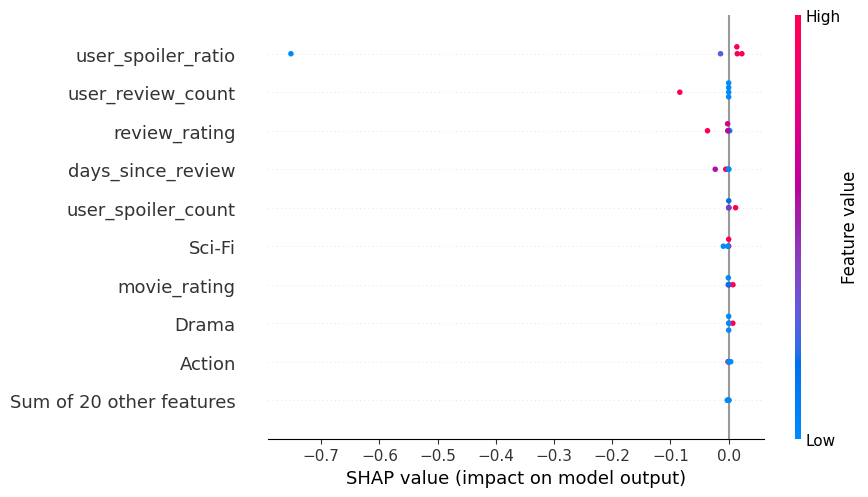

In [87]:
import shap
import torch
import numpy as np

# Make sure model is in eval mode on CPU
model.eval()
model.cpu()

# Prepare small background and to_explain samples (structured features only)
n_background = 2
n_explain = 5

background = torch.stack([val_dataset[i]['additional_features'] for i in range(n_background)]).numpy()
to_explain = torch.stack([val_dataset[i]['additional_features'] for i in range(n_explain)]).numpy()

# Wrapper for structured features only
class StructuredOnlyWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, structured_input):
        structured_tensor = torch.tensor(structured_input, dtype=torch.float)
        batch_size = structured_tensor.shape[0]
        dummy_input_ids = torch.zeros((batch_size, 128), dtype=torch.long)
        dummy_attention_mask = torch.ones((batch_size, 128), dtype=torch.long)
        with torch.no_grad():
            logits = self.model(
                input_ids=dummy_input_ids,
                attention_mask=dummy_attention_mask,
                additional_features=structured_tensor
            ).logits
        return torch.softmax(logits, dim=1).numpy()

# Use a masker designed for tabular data
masker = shap.maskers.Independent(data=background)

# Create the SHAP explainer
explainer = shap.Explainer(StructuredOnlyWrapper(model), masker=masker)

# Compute SHAP values
shap_values = explainer(to_explain)
shap_values.feature_names = additional_feature_cols

# For binary classification, get SHAP values for class 1
shap_values_class1 = shap_values[..., 1]  # Ellipsis slices across samples and then picks class 1

# Visualize
shap.plots.beeswarm(shap_values_class1)


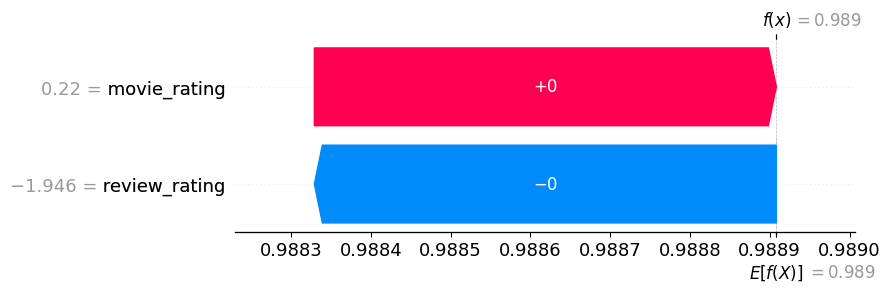

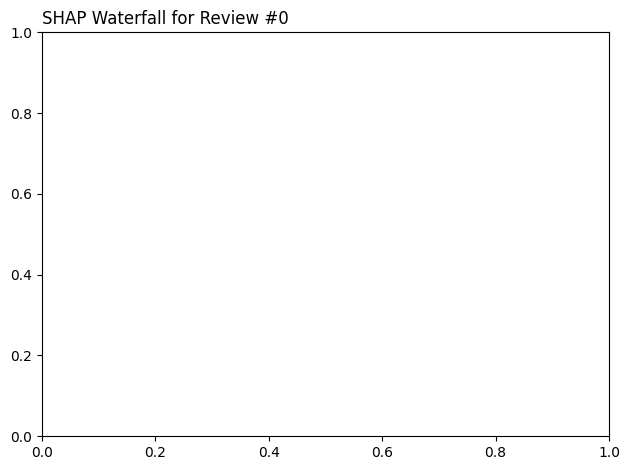

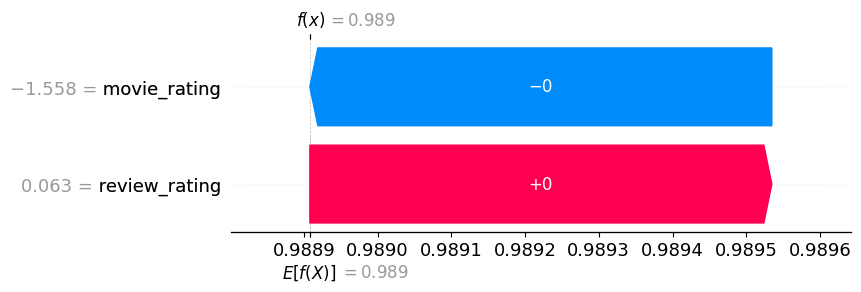

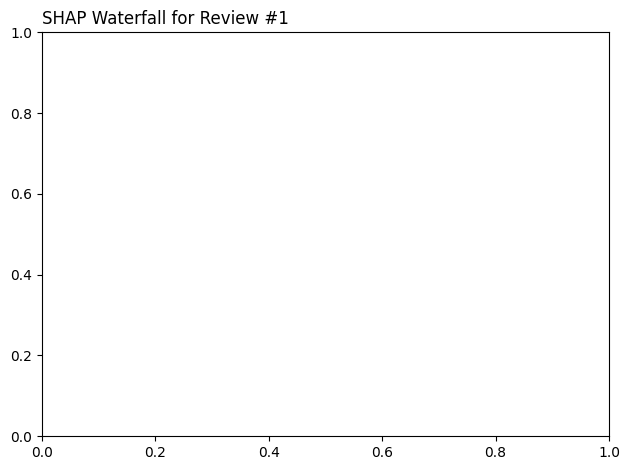

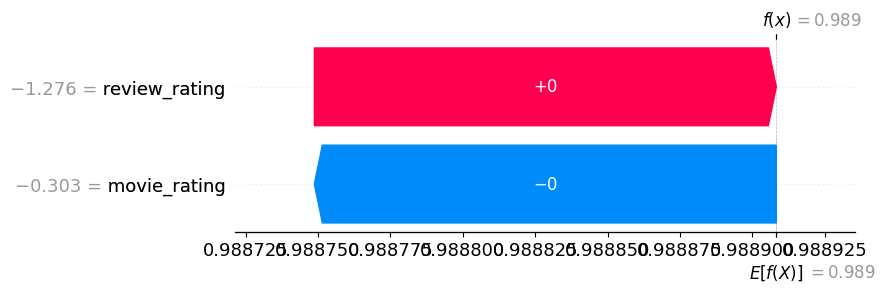

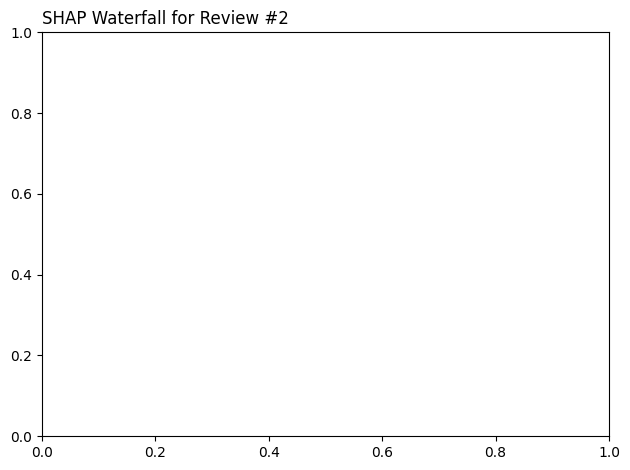

In [94]:
import shap
import matplotlib.pyplot as plt

n_instances = 3  # Number of reviews

for i in range(n_instances):
    # Create fresh figure for each plot
    plt.figure(figsize=(6, 4))
    
    # Extract SHAP explanation for review i, class 1
    instance_shap = shap.Explanation(
        values=shap_values.values[i, 1],
        base_values=shap_values.base_values[i, 1],
        data=shap_values.data[i],
        feature_names=shap_values.feature_names
    )
    
    shap.plots.waterfall(instance_shap, max_display=10)
    plt.title(f"SHAP Waterfall for Review #{i}", loc="left")
    plt.tight_layout()
    plt.show()
